In [20]:
import pandas as pd
import numpy as np
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import re
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

folder_path_train = "..\\data\\cleaned\\train"
folder_path_test = "..\\data\\cleaned\\test"
names = ["Facebook", "Reddit", "Twitter", "Youtube"]
dfs_train = {}
dfs_test = {}

for n in names:
    dfs_train[n] = pd.read_csv(os.path.join(folder_path_train, f"{n.lower()}_train.csv"))
    dfs_test[n] = pd.read_csv(os.path.join(folder_path_test, f"{n.lower()}_test.csv"))



In [21]:
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vital\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vital\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

for name in names:
    dfs_train[name]['tokens'] = dfs_train[name]['text'].apply(preprocess_text)
    dfs_test[name]['tokens'] = dfs_train[name]['text'].apply(preprocess_text)
    dfs_train[name]['label'] = dfs_train[name]['label'].astype(int)
    dfs_test[name]['label'] = dfs_test[name]['label'].astype(int)


In [23]:
#dO DATA cleaning 
#search: data cleaning in text mining to clean twitter data
# after data cleaning i need to check the data

In [24]:
word2vec_models = {}
for name in dfs_train.keys():
    sentences = dfs_train[name]['tokens'].tolist()
    model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
    word2vec_models[name] = model

def get_sentence_embedding(tokens, model):
    # Get the embeddings for each token
    embeddings = [model.wv[word] for word in tokens if word in model.wv]
    # Average the embeddings to get the sentence embedding
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

for name in dfs_train.keys():
    dfs_train[name]['embedding'] = dfs_train[name]['tokens'].apply(lambda x: get_sentence_embedding(x, word2vec_models[name]))
    dfs_test[name]['embedding'] = dfs_test[name]['tokens'].apply(lambda x: get_sentence_embedding(x, word2vec_models[name]))



In [25]:
for name in dfs_train.keys():
    print(f"Class distribution in train set for {name}:")
    print(dfs_train[name]['label'].value_counts())
    print(f"Class distribution in test set for {name}:")
    print(dfs_test[name]['label'].value_counts())


Class distribution in train set for Facebook:
label
1    845
0    353
Name: count, dtype: int64
Class distribution in test set for Facebook:
label
1    211
0     89
Name: count, dtype: int64
Class distribution in train set for Reddit:
label
0    10943
1     3011
Name: count, dtype: int64
Class distribution in test set for Reddit:
label
0    2736
1     753
Name: count, dtype: int64
Class distribution in train set for Twitter:
label
1    16496
0     3330
Name: count, dtype: int64
Class distribution in test set for Twitter:
label
1    4124
0     833
Name: count, dtype: int64
Class distribution in train set for Youtube:
label
1    1891
0     685
Name: count, dtype: int64
Class distribution in test set for Youtube:
label
1    473
0    172
Name: count, dtype: int64


In [26]:

for name in dfs_train.keys():
    X_test = np.vstack(dfs_test[name]['embedding'].values)
    y_test = dfs_test[name]['label']
    
    classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    classifier.fit(np.vstack(dfs_train[name]['embedding'].values), dfs_train[name]['label'])
    y_pred = classifier.predict(X_test)
    
    print(f"Predicted class distribution for {name}:")
    print(pd.Series(y_pred).value_counts())

Predicted class distribution for Facebook:
1    214
0     86
Name: count, dtype: int64
Predicted class distribution for Reddit:
0    2743
1     746
Name: count, dtype: int64
Predicted class distribution for Twitter:
1    4163
0     794
Name: count, dtype: int64
Predicted class distribution for Youtube:
1    474
0    171
Name: count, dtype: int64


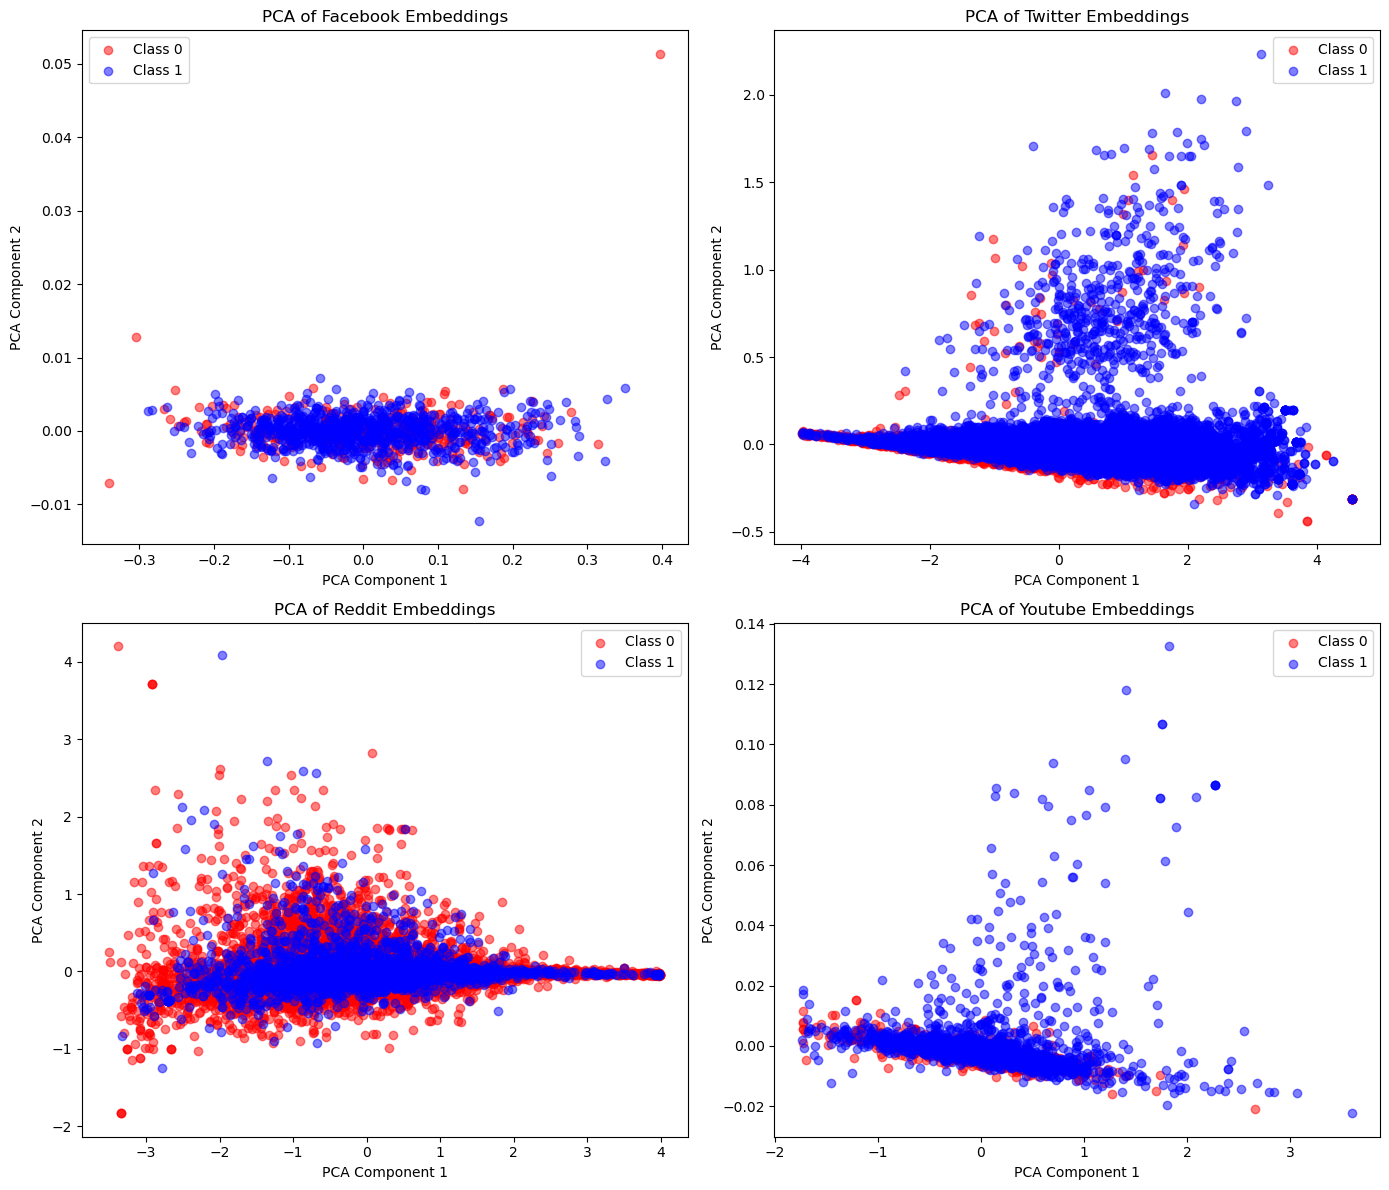

In [27]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Plot embeddings for each dataset
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

datasets = ['Facebook', 'Twitter', 'Reddit', 'Youtube']
for ax, name in zip(axs.flatten(), datasets):
    pca = PCA(n_components=2)
    embeddings = np.vstack(dfs_train[name]['embedding'].values)
    labels = dfs_train[name]['label'].values
    reduced_embeddings = pca.fit_transform(embeddings)
    
    ax.scatter(reduced_embeddings[labels == 0, 0], reduced_embeddings[labels == 0, 1], c='red', label='Class 0', alpha=0.5)
    ax.scatter(reduced_embeddings[labels == 1, 0], reduced_embeddings[labels == 1, 1], c='blue', label='Class 1', alpha=0.5)
    ax.set_title(f'PCA of {name} Embeddings')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.legend()

plt.tight_layout()
plt.show()

In [28]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

results = []

# Train on each dataset and test on all datasets
for train_name in names:
    # Prepare training data
    X_train = np.vstack(dfs_train[train_name]['embedding'].values)
    y_train = dfs_train[train_name]['label']
    
    # Train the classifier
    classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    classifier.fit(X_train, y_train)
    
    for test_name in names:
        # Prepare testing data
        X_test = np.vstack(dfs_test[test_name]['embedding'].values)
        y_test = dfs_test[test_name]['label']
        
        # Predict on the test data
        y_pred = classifier.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Collect results for each class
        for cls in ['0', '1']:
            results.append({
                'Train Dataset': train_name,
                'Test Dataset': test_name,
                'Class': cls,
                'Precision': report[cls]['precision'],
                'Recall': report[cls]['recall'],
                'F1-Score': report[cls]['f1-score'],
                'Accuracy': np.nan  # Accuracy is not class-specific
            })
        
        # Include the overall metrics for the test dataset
        results.append({
            'Train Dataset': train_name,
            'Test Dataset': test_name,
            'Class': 'overall',
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Accuracy': accuracy
        })

# Train on combined datasets and test on each dataset separately
X_train_combined = np.vstack([np.vstack(dfs_train[name]['embedding'].values) for name in names])
y_train_combined = np.hstack([dfs_train[name]['label'] for name in names])

# Train the classifier on combined datasets
classifier_combined = RandomForestClassifier(n_estimators=100, random_state=42)
classifier_combined.fit(X_train_combined, y_train_combined)

for test_name in names:
    # Prepare testing data
    X_test = np.vstack(dfs_test[test_name]['embedding'].values)
    y_test = dfs_test[test_name]['label']
    
    # Predict on the test data
    y_pred = classifier_combined.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Collect results for each class
    for cls in ['0', '1']:
        results.append({
            'Train Dataset': 'combined',
            'Test Dataset': test_name,
            'Class': cls,
            'Precision': report[cls]['precision'],
            'Recall': report[cls]['recall'],
            'F1-Score': report[cls]['f1-score'],
            'Accuracy': np.nan  # Accuracy is not class-specific
        })
    
    # Include the overall metrics for the test dataset
    results.append({
        'Train Dataset': 'combined',
        'Test Dataset': test_name,
        'Class': 'overall',
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Accuracy': accuracy
    })

results_df = pd.DataFrame(results)

# Save the results DataFrame to a CSV file
results_df.to_csv('results/w2v_classification_results.csv', index=False)

# Display the results DataFrame
print(results_df)


   Train Dataset Test Dataset    Class  Precision    Recall  F1-Score  \
0       Facebook     Facebook        0   0.220930  0.213483  0.217143   
1       Facebook     Facebook        1   0.672897  0.682464  0.677647   
2       Facebook     Facebook  overall   0.538814  0.543333  0.541031   
3       Facebook       Reddit        0   0.784094  0.998173  0.878276   
4       Facebook       Reddit        1   0.166667  0.001328  0.002635   
5       Facebook       Reddit  overall   0.650840  0.783032  0.689294   
6       Facebook      Twitter        0   0.168113  1.000000  0.287837   
7       Facebook      Twitter        1   1.000000  0.000485  0.000969   
8       Facebook      Twitter  overall   0.860205  0.168449  0.049176   
9       Facebook      Youtube        0   0.268025  0.994186  0.422222   
10      Facebook      Youtube        1   0.857143  0.012685  0.025000   
11      Facebook      Youtube  overall   0.700045  0.274419  0.130926   
12        Reddit     Facebook        0   0.296667  